In [37]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import os
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import classification_report
import numpy as np

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ─── SETUP ────────────

In [6]:
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

MODEL_NAME = "openai/clip-vit-base-patch32"

model = CLIPModel.from_pretrained(MODEL_NAME).to(DEVICE)
processor = CLIPProcessor.from_pretrained(MODEL_NAME)

Using device: mps


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# ─── CLASS DEFINITIONS ──────

In [62]:
#CLASS_NAMES = [
#    "a photo of type-1 stool",
#    "a photo of type-2 stool",
#    "a photo of type-3 stool",
#    "a photo of type-4 stool",
#    "a photo of type-5 stool",
#    "a photo of type-6 stool",
#    "a photo of type-7 stool"
#]

#CLASS_NAMES = [
#    "a photo of type-1 stool on Bistol Stool Chart",
#    "a photo of type-2 stool on Bistol Stool Chart",
#    "a photo of type-3 stool on Bistol Stool Chart",
#    "a photo of type-4 stool on Bistol Stool Chart",
#    "a photo of type-5 stool on Bistol Stool Chart",
#    "a photo of type-6 stool on Bistol Stool Chart",
#    "a photo of type-7 stool on Bistol Stool Chart"
#]

CLASS_NAMES = [
    "Separated hard lumps, like nuts",
    "Sausage-shaped but lumpy",
    "Like a sausage but with cracks on its surface",
    "Like a sausage or snake, smooth and soft",
    "Soft blobs with clear-cut edges",
    "Fluffy pieces with ragged edges, a mushy stool",
    "Watery, no solid pieces, entirely liquid",
]

#CLASS_NAMES = [f"Bristol Stool Chart Type {c}" for c in [1,2,3,4,5,6,7]]

print(f"We have {len(CLASS_NAMES)} classes.")
for i, name in enumerate(CLASS_NAMES):
    print(f"{i}: {name}")


We have 7 classes.
0: Separated hard lumps, like nuts
1: Sausage-shaped but lumpy
2: Like a sausage but with cracks on its surface
3: Like a sausage or snake, smooth and soft
4: Soft blobs with clear-cut edges
5: Fluffy pieces with ragged edges, a mushy stool
6: Watery, no solid pieces, entirely liquid


# ─── LOAD IMAGES ───────

In [63]:
def load_images_from_folder(folder):
    image_paths, labels = [], []
    for label_idx, class_name in enumerate(sorted(os.listdir(folder))):
        
        class_dir = Path(folder) / class_name

        print(f"Loading images from: {class_dir}")
        if not class_dir.is_dir():
            continue

        counter = 0
        for img_file in class_dir.glob("*.jpg"):
            image_paths.append(str(img_file))
            labels.append(label_idx)
            counter += 1
        
        print(f"Loaded {counter} images from {class_name}")
    return image_paths, labels

# ─── INFERENCE ──────────

In [64]:
def classify_clip(image_paths):
    predictions = []
    with torch.no_grad():
        for path in tqdm(image_paths, desc="Classifying images"):
            image = Image.open(path).convert("RGB")
            inputs = processor(text=CLASS_NAMES, images=image, return_tensors="pt", padding=True).to(DEVICE)
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image  # image-text similarity
            probs = logits_per_image.softmax(dim=1)
            pred = probs.argmax().item()
            predictions.append(pred)
    return predictions

# ─── MAIN EXECUTION ────

In [65]:
!find ../data -name ".DS_Store" -type f -delete

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [66]:
TEST_DIR = "../data"  # <-- CHANGE TO YOUR TEST IMAGE DIR
image_paths, true_labels = load_images_from_folder(TEST_DIR)
preds = classify_clip(image_paths)

Loading images from: ../data/type-1
Loaded 117 images from type-1
Loading images from: ../data/type-2
Loaded 120 images from type-2
Loading images from: ../data/type-3
Loaded 324 images from type-3
Loading images from: ../data/type-4
Loaded 302 images from type-4
Loading images from: ../data/type-5
Loaded 22 images from type-5
Loading images from: ../data/type-6
Loaded 24 images from type-6
Loading images from: ../data/type-7
Loaded 75 images from type-7


Classifying images:   0%|          | 0/984 [00:00<?, ?it/s]

Classifying images: 100%|██████████| 984/984 [00:22<00:00, 44.23it/s]


# ─── EVALUATION ─────

In [75]:
print("\nClassification Report:")
print(classification_report(true_labels, preds, target_names=[f"type-{i+1}" for i in range(7)]))


Classification Report:
              precision    recall  f1-score   support

      type-1       0.16      0.79      0.26       117
      type-2       0.09      0.12      0.10       120
      type-3       0.44      0.02      0.04       324
      type-4       0.57      0.22      0.31       302
      type-5       0.00      0.00      0.00        22
      type-6       0.15      0.12      0.14        24
      type-7       0.25      0.25      0.25        75

    accuracy                           0.20       984
   macro avg       0.24      0.22      0.16       984
weighted avg       0.37      0.20      0.18       984



# ─── Error analysis ────

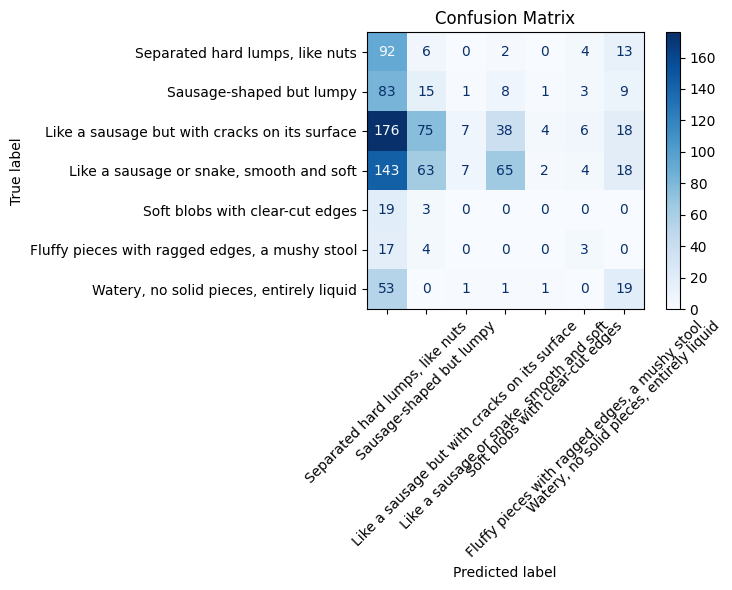

In [ ]:
cm = confusion_matrix(true_labels, preds, labels=list(range(len(CLASS_NAMES))))

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=True, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [73]:
print(cm)

[[ 92   6   0   2   0   4  13]
 [ 83  15   1   8   1   3   9]
 [176  75   7  38   4   6  18]
 [143  63   7  65   2   4  18]
 [ 19   3   0   0   0   0   0]
 [ 17   4   0   0   0   3   0]
 [ 53   0   1   1   1   0  19]]


In [74]:
def show_misclassified(image_paths, preds, true_labels, max_display=6):
    wrong = [(p, t, img) for p, t, img in zip(preds, true_labels, image_paths) if p != t]
    if not wrong:
        print("No misclassified samples.")
        return
    for i, (pred, true, img_path) in enumerate(wrong[:max_display]):
        img = Image.open(img_path).convert("RGB")
        plt.figure()
        plt.imshow(img)
        plt.title(f"True: type-{true+1}, Pred: type-{pred+1}")
        plt.axis("off")
    plt.show()
# show_misclassified(image_paths, preds, true_labels)